# CAS ADS 2024 - M1 Project
Author: **Marcel Grosjean**

### **/!\ The scrapping part  will not work properly on Google Collab /!\**



I had started working on this project in Google Colab, but making requests from Colab to homegate.ch was complicated since most of my requests were blocked. So, I did everything locally, which works much better.

The purpose of this project is to scrape the entire homegate.ch website to collect all rental listings and generate statistics based on the data. The focus will exclusively be on rental apartments, excluding other types of rental listings such as parking spaces, houses, commercial properties, etc. Sales listings will not be considered.

We will only perform the scraping once due to the technical complexity involved. There may be instances where we do not obtain data for all municipalities, and the pricing in the listings may not accurately represent market averages, as we are only capturing data from a single point in time.

This approach will provide a snapshot of the rental market, but we must acknowledge its limitations regarding comprehensiveness and accuracy.

# 1. Project setup
First I need to install the necessary packages.
The fake-useragent package is used to generate fake user agent.

In [2]:
!pip install fake-useragent geopandas matplotlib

Import some libraries:

In [3]:
import requests
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from bs4 import BeautifulSoup
import time
import math
import random
import json
from fake_useragent import UserAgent
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt


Let's create some constants and functions that are needed in this document:

In [4]:
ua = UserAgent()

# This function is called at every query to generate a new http query headers
def generate_headers():
  return {
    'User-Agent': ua.random, # set random user agent
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate, br',
    'Connection': 'keep-alive',
    'Upgrade-Insecure-Requests': '1',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'none',
    'Sec-Fetch-User': '?1',
    'TE': 'Trailers'
}

# function to create a requests session with retry logic
def create_requests_session_with_retries():
    session = requests.Session()
    retries = Retry(
        total = 5,
        backoff_factor = 1,
        status_forcelist = [500, 502, 503, 504],  # Retry on these status codes
        allowed_methods = ["GET"],
    )
    adapter = HTTPAdapter(max_retries=retries)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

# extract number from a string
def extract_number_from_string(input_string):
    numeric_string = ''.join([char for char in input_string if char.isdigit()])
    if numeric_string:
        return int(numeric_string)
    else:
        return None

# replace all the comas in a string, except the last one
def replace_commas(s):
    parts = s.split(',')

    if len(parts) <= 1:
        return s

    return '.'.join(parts[:-1]) + ',' + parts[-1]

# Dictionary mapping of canton abbreviations to full names
def get_canton_name(abbreviation):
    canton_map = {
        'AG': 'Aargau', 'AR': 'Appenzell Ausserrhoden', 'AI': 'Appenzell Innerrhoden',
        'BL': 'Basel-Landschaft', 'BS': 'Basel-Stadt', 'BE': 'Bern', 'FR': 'Fribourg',
        'GE': 'Genève', 'GL': 'Glarus', 'GR': 'Graubünden', 'JU': 'Jura', 'LU': 'Lucerne',
        'NE': 'Neuchâtel', 'NW': 'Nidwalden', 'OW': 'Obwalden', 'SZ': 'Schwyz',
        'SH': 'Schaffhausen', 'SO': 'Solothurn', 'SG': 'Sankt Gallen', 'TG': 'Thurgau',
        'TI': 'Ticino', 'UR': 'Uri', 'VS': 'Valais', 'VD': 'Vaud', 'ZG': 'Zug', 'ZH': 'Zürich'
    }

    # Return the corresponding full canton name, or None if not found
    return canton_map.get(abbreviation.upper(), None)

# 2. Query homegate.ch
**You do not need to execute chapter 2 in Google Collab. You can jump into chapter 3 and run all the code from there. All the data needed are in chapter 3**
## 2.1 Query the cantons
Making requests to homegate.ch is quite challenging. It's not possible to do this on Google Colab because Google's IPs are blocked. As a result, I had to run the process on a local Jupyter notebook instance.

Additionally, homegate aggressively applies rate limiting through Cloudflare's proxy. If too many requests are made, Cloudflare blocks access for 12 hours.

After some trial and error, I found that waiting 10 seconds between each request prevents getting blocked.

We begin by searching for all the links to the listings for each canton.

We start by querying all the cantons:

In [ ]:
session = create_requests_session_with_retries()

cantons_url = "https://www.homegate.ch/rent/apartment/switzerland"
cantons_results = session.get(cantons_url, headers=generate_headers())
cantons_results.encoding = 'utf-8'

print(f"Get all the cantons from {cantons_url}")
print(f"Status code: {cantons_results.status_code}")

cantons_page = BeautifulSoup(cantons_results.text)
cantons = []
for arr in cantons_page.select('[class^="row GeoDrillDownLocationsSection_spacer_"]'):
    # get the links to all the cantons
    main_div = arr.findChild()
    link_tag = main_div.findChild()

    # region full name
    canton = link_tag.text

    # we skip regions that are not Swiss canton. It must contain the "Canton" string in its text
    if "Canton" not in canton:
        continue

    # only keep the canton name
    canton = canton.split("Canton")[1].strip()
    cantons.append({"canton": canton, "url": f"https://www.homegate.ch{link_tag["href"]}"})

print(f"NB Cantons: {len(cantons)}")
print(f"First canton: {cantons[0]}")

Get all the cantons from https://www.homegate.ch/rent/apartment/switzerland
Status code: 200
NB Cantons: 26
First canton: {'canton': 'Aargau', 'url': 'https://www.homegate.ch/rent/apartment/canton-aargau'}


The *cantons* list contains the following informations:
[{
    canton: string,
    url: string
}]

Where the url is the link to all the districts.

## 2.2 Query the regions

There is a tricky part now, all pages for a canton may have listing for a region (district) or cities but not both.
We need to check if this is a district or cities listing and add links acordingly.


In [ ]:
session = create_requests_session_with_retries()

listings_list_pages = []
# we try the smallest listing possible per canton
for canton in cantons:
    canton_page = session.get(canton["url"], headers=generate_headers())
    canton_page.encoding = 'utf-8'

    # parse the page
    canton_links_page = BeautifulSoup(canton_page.text)

    # get a parent tag and navigate to the links
    parent = canton_links_page.select('[class^="GeoDrilldownPage_rootTitle_zNMQr"]')
    parent = parent[0].nextSibling.nextSibling.find_all()
    regions = parent[1]

    # extract the links and store it in the list
    links = []
    for region in regions:
        link = f"https://www.homegate.ch{region.find("a")["href"]}"
        if "/matching-list" not in link: # listing page
            link += "/matching-list"
        link += "?ipd=true" # we only keep listing that have a price
        links.append(link)

    listings_list_pages.append({
        "canton": canton["canton"],
        "links": links
    })
    print(f"Done for {canton["canton"]}")
    time.sleep(10)


for ct in listings_list_pages:
    print(ct["canton"])
    for link in ct["links"]:
        print(link)
    print()
#print(listings_list_pages)


Done for Aargau
Done for Appenzell Ausserrhoden
Done for Appenzell Innerrhoden
Done for Basel-Land
Done for Basel-Stadt
Done for Bern
Done for Fribourg
Done for Geneva
Done for Glarus
Done for Graubünden
Done for Jura
Done for Lucerne
Done for Neuchâtel
Done for Nidwalden
Done for Obwalden
Done for Schaffhausen
Done for Schwyz
Done for Solothurn
Done for St. Gallen
Done for Thurgau
Done for Ticino
Done for Uri
Done for Valais
Done for Vaud
Done for Zug
Done for Zurich
Aargau
https://www.homegate.ch/rent/apartment/region-aarau/matching-list?ipd=true
https://www.homegate.ch/rent/apartment/region-baden/matching-list?ipd=true
https://www.homegate.ch/rent/apartment/region-bremgarten/matching-list?ipd=true
https://www.homegate.ch/rent/apartment/region-brugg/matching-list?ipd=true
https://www.homegate.ch/rent/apartment/region-kulm/matching-list?ipd=true
https://www.homegate.ch/rent/apartment/region-laufenburg/matching-list?ipd=true
https://www.homegate.ch/rent/apartment/region-lenzburg/matchi

## 2.3 Query the listings

Now we're going to get the number of listing and pages for each region or city.

In [ ]:
start_time = time.time()
session = create_requests_session_with_retries()

# contains all the listings
listings = []

# we also write the results in a "listings.txt" as the process may break anytime
with open("listings.txt", "w") as file:
    # for each cantons, we'll get all the listings
    for infos in listings_list_pages:
        print(f"{infos["canton"]}:")

        for link in infos["links"]:


            # now we want to find out the number of listings and pages for a given region
            infos_page = requests.get(link, headers=generate_headers())
            infos_page.encoding = 'utf-8'

            # parse the page
            infos = BeautifulSoup(infos_page.text)
            # number of listings for this region
            nb = extract_number_from_string(infos.find_all(class_="ResultListHeader_locations_bold_OhksP")[0].text)
            # number of pages  for this listing
            pages = math.ceil(nb/20)
            if pages > 50: # we can handle at most 50 pages with the homegate ui
                pages = 50

            print(f" {link.split("/")[5]} {nb} listings for {pages} pages")

            if nb == 0: # no listing for this district
                continue

            # query all the pages
            print(f"  Page: ", end="")
            for i in range(1, pages + 1):
                # get the specific page
                target_page_link = f"{link}&page={i}"
                target_page = session.get(target_page_link, headers=generate_headers())
                target_page.encoding = 'utf-8'

                target_page = BeautifulSoup(target_page.text)

                # cards contains the informations about a listing
                cards = target_page.find_all(class_="HgListingCard_info_RKrwz")
                for card in cards:
                    # get the price, space and address
                    listing_informations = {
                        "price": card.find_all(class_="HgListingCard_price_JoPAs")[0].text.strip(),
                        "space": card.find_all(class_="HgListingRoomsLivingSpace_roomsLivingSpace_GyVgq")[0].text.strip(),
                        "address": card.find_all(class_="HgListingCard_address_JGiFv")[0].text.strip()
                    }
                    #print(listing_informations)
                    # store in the listings list
                    listings.append(listing_informations)
                    # and store it in the file
                    file.write(f"{listing_informations}\n")


                # DO NOT REMOVE THIS !!!
                time.sleep(10)

                print(f"{i} ", end="")
                #break

            print()

            # DO NOT REMOVE THIS !!!
            time.sleep(10)
            #break


        print()

        #break

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Done in {elapsed_time:.2f} seconds.")

Aargau:
 region-aarau 145 listings for 8 pages
  Page: 1 2 3 4 5 6 7 8 
 region-baden 261 listings for 14 pages
  Page: 1 2 3 4 5 6 7 8 9 10 11 12 13 14 
 region-bremgarten 135 listings for 7 pages
  Page: 1 2 3 4 5 6 7 
 region-brugg 101 listings for 6 pages
  Page: 1 2 3 4 5 6 
 region-kulm 113 listings for 6 pages
  Page: 1 2 3 4 5 6 
 region-laufenburg 95 listings for 5 pages
  Page: 1 2 3 4 5 
 region-lenzburg 125 listings for 7 pages
  Page: 1 2 3 4 5 6 7 
 region-muri 64 listings for 4 pages
  Page: 1 2 3 4 
 region-rheinfelden 133 listings for 7 pages
  Page: 1 2 3 4 5 6 7 
 region-zofingen 203 listings for 11 pages
  Page: 1 2 3 4 5 6 7 8 9 10 11 
 region-zurzach 86 listings for 5 pages
  Page: 1 2 3 4 5 

Appenzell Ausserrhoden:
 region-hinterland 77 listings for 4 pages
  Page: 1 2 3 4 
 region-mittelland 51 listings for 3 pages
  Page: 1 2 3 
 region-vorderland 53 listings for 3 pages
  Page: 1 2 3 

Appenzell Innerrhoden:
 city-appenzell 8 listings for 1 pages
  Page: 1 
 

As you can see, the whole process took **4.5 hours** to scrape only the appartments for rent in Switzerland !

Let's check how many results we have got:

In [ ]:
print(f"We managed to scrape {len(listings)} results")

We managed to scrape 24379 results



# 3. Data cleaning

**You can execute all the codes in Google Collab from this chapter until the end. Just make sure to execute all the code in chapter 1 aswell.**

The parts 1 and 2 were done on a jupyter notebook running locally.
From here, the notebook was brought back to Google Coolab and the rest was done here.

## 3.1 Cleaning

We'll parse all the results from the file *listings.txt* and do some cleaning. We store all the listings in the following format:

[{
    "price": price,
    "surface": surface,
    "rooms": rooms,
    "cp": cp,
    "municipality": municipality
  }
]


In [6]:
listings_clean = []

# get the data that were generated on the local and stored in the following url
url_listings = "https://static.grosjean.io/cas/listings.txt"
response = requests.get(url_listings)
response.encoding = "utf-8"

i = 0
# read the file line by line and do some data cleaning
for line in response.text.splitlines():
  # parse str to json
  listing = line.replace("'", '"')
  listing = json.loads(listing)

  price = extract_number_from_string(listing["price"][4:][:-10])
  space = listing["space"].strip()
  address = replace_commas(listing["address"])

  # we filter out appartments that have no price
  if price is None:
    continue

  # we filter out appartments that have no rooms or living space
  if "rooms" not in space or "space" not in space:
    continue

  # there is a cp and canton, but not always an address
  if "," in address:
    street = address.split(",")[0].strip()
    cp = int(address.split(",")[1].strip().split(" ")[0].strip())
    municipality = address.split(",")[1].strip()[5:]
  else:
    street = "-"
    cp = int(address.split(" ")[0].strip())
    municipality = address.strip()[5:]

  rooms = float(space.split("rooms")[0].strip())
  surface = int(space.split("rooms")[1].strip()[:-15])

  # if the the municioality ends withtwo uppercase letter
  # then we remove the last 3 characters
  #if municipality[-2:].isupper():
  #  municipality = municipality[:-3]

  listings_clean.append({
    "price": price,
    "surface": surface,
    "rooms": rooms,
    "cp": cp,
    "municipality": municipality
  })

print(f"There are {len(listings_clean)} cleaned listings")
#listings_clean


There are 21264 cleaned listings


## 3.2 Map the listings to a canton
So far we got the data with the following structure:

{
  "price": int,
  "surface": int,
  "rooms": string,
  "cp": int,
  "municipality": string
}

What we want to do is to get the canton for each listing. This was possible to get the canton directly from homegate.ch but the results were not always consistent. So we got a file that has all the postal codes maped to its corresponding canton and map our cp to the right canton:

In [7]:
#swiss = {"CP": "canton_name"}
swiss = {}
# read the csv file that map a postal code to canton
url_listings = "https://raw.githubusercontent.com/gamba/swiss-geolocation/refs/heads/master/post-codes.csv"
response = requests.get(url_listings)
response.encoding = "utf-8"

# a simple list of all the municipalities
all_municipalities = []
for line in response.text.splitlines()[4:]:
  line = line.split(',')
  all_municipalities.append(line[1])

# start to read the file at line 4
for line in response.text.splitlines()[4:]:
  line = line.split(',')
  cp = line[0]
  canton = get_canton_name(line[4])
  if canton is not None:
    swiss[str(cp)] = canton

print(f"There are {len(swiss.keys())} DISTINCTS postal codes")

# now we are adding the cantons to the municipalities
for listing in listings_clean:
  listing["canton"] = swiss[str(listing["cp"])]

There are 3392 DISTINCTS postal codes


# 4. Data visualisation
## 4.1 Municipalities heatmap

We now have all the necessary data for our data visualization. The data has been acquired, cleaned, and is ready to be used. The first chart we'll display is a heatmap of average rental prices by municipality. You will notice that some municipalities are missing from the map. This is because there are listings for only 929 municipalities in total. Municipalities without any listings are not displayed. A future improvement could be to display the missing municipalities and assign them the average rent of their canton.

Here we're going to plot all the municipalities:


There are 929 distincts municipalities.


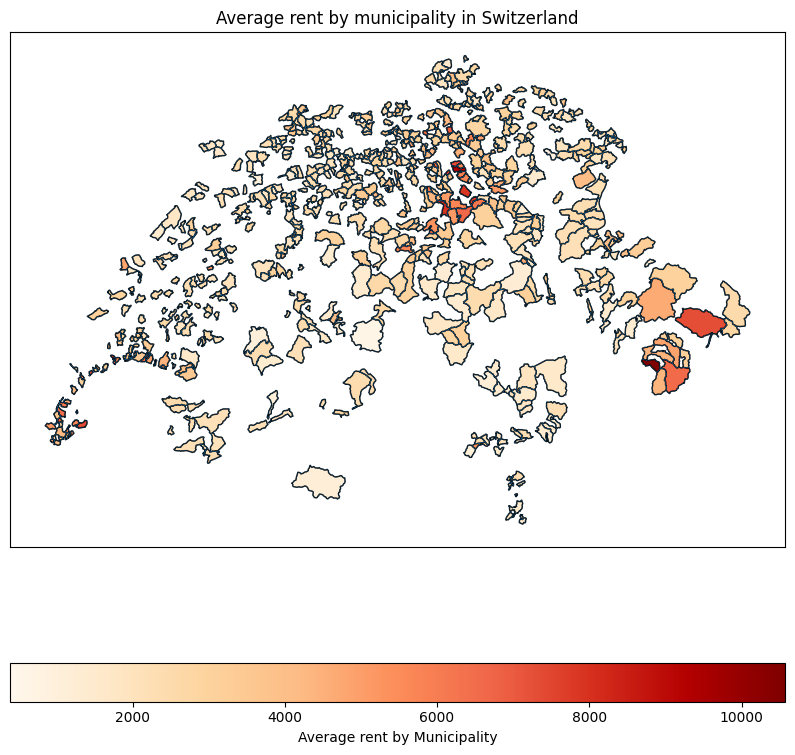

In [8]:

# list of all municipalities and remove the duplicates
municipalities = []
for listing in listings_clean:
  if listing["municipality"] not in municipalities:
    municipalities.append(listing["municipality"])

# compute the average rent for each municipality
rents_avg_per_municipality = []
for municipality in municipalities:
  rents = []
  for listing in listings_clean:
    if listing["municipality"] == municipality:
      rents.append(listing["price"])
  average = sum(rents) / len(rents)
  rents_avg_per_municipality.append(average)

print(f"There are {len(municipalities)} distincts municipalities.")


# Load Switzerland municipalities shapefile (replace the URL with a local or valid online shapefile for municipalities)
shape_file = 'https://static.grosjean.io/cas/CHE_adm3.shp'
switzerland = gpd.read_file(shape_file)
# Example population data for a few municipalities (fictional data)
population_data = {
    'municipality': municipalities,
    'population': rents_avg_per_municipality
}
population_df = pd.DataFrame(population_data)

# Filter the geodata for selected municipalities and merge with population data
#switzerland = switzerland[switzerland['NAME_1'].isin(population_df['canton'])]
switzerland = switzerland.merge(population_df, left_on='NAME_3', right_on='municipality')

# Plotting the municipalities with population data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
switzerland.boundary.plot(ax=ax, linewidth=0.2)  # Plot boundaries
switzerland.plot(column='population', ax=ax, legend=True,
                 legend_kwds={'label': "Average rent by Municipality",
                              'orientation': "horizontal"},
                 cmap='OrRd', edgecolor='black')

# Title and show plot
plt.xticks([])
plt.yticks([])
plt.title('Average rent by municipality in Switzerland')
plt.show()

# 4.2 Cantons heatmap
We will now display a heatmap showing the average rent for each canton.

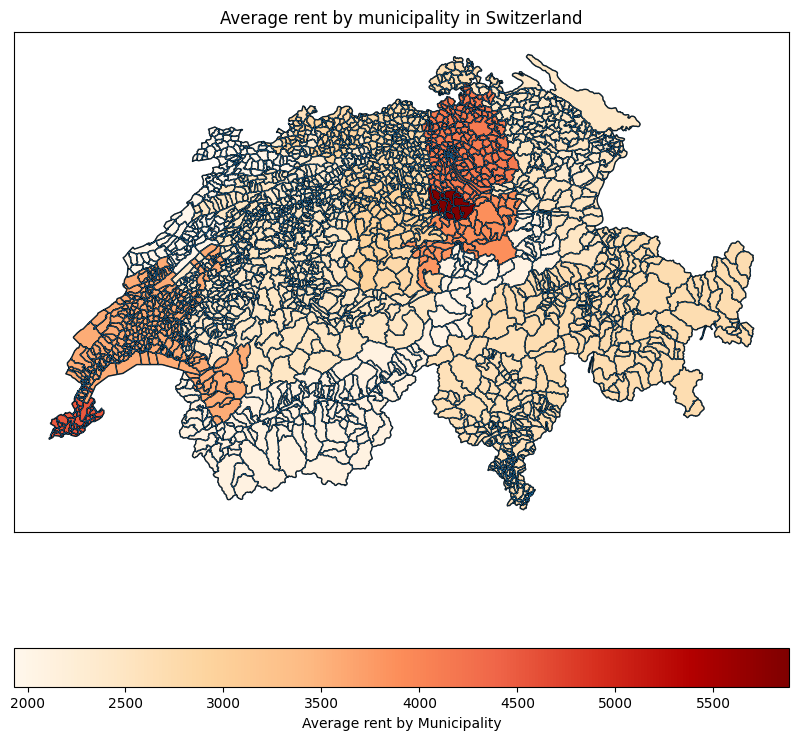

In [9]:
# list of all municipalities and remove the duplicates
cantons = []
for listing in listings_clean:
  if listing["canton"] not in cantons:
    cantons.append(listing["canton"])

# compute the average rent for each municipality
rents_avg_per_canton = []
for canton in cantons:
  rents = []
  for listing in listings_clean:
    if listing["canton"] == canton:
      rents.append(listing["price"])
  average = sum(rents) / len(rents)
  rents_avg_per_canton.append(average)

#print(f"Rent per canton")
#for i in range(0, len(cantons)):
#  print(f"{cantons[i]}: {rents_avg_per_canton[i]:.2f}")

# Load Switzerland municipalities shapefile (replace the URL with a local or valid online shapefile for municipalities)
shape_file = 'https://static.grosjean.io/cas/CHE_adm3.shp'
switzerland = gpd.read_file(shape_file)
# Example population data for a few municipalities (fictional data)
population_data = {
    'canton': cantons,
    'population': rents_avg_per_canton
}
population_df = pd.DataFrame(population_data)

# Filter the geodata for selected municipalities and merge with population data
#switzerland = switzerland[switzerland['NAME_1'].isin(population_df['canton'])]
switzerland = switzerland.merge(population_df, left_on='NAME_1', right_on='canton')

# Plotting the municipalities with population data
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
switzerland.boundary.plot(ax=ax, linewidth=0.2)  # Plot boundaries
switzerland.plot(column='population', ax=ax, legend=True,
                 legend_kwds={'label': "Average rent by Municipality",
                              'orientation': "horizontal"},
                 cmap='OrRd', edgecolor='black')

# Title and show plot
plt.xticks([])
plt.yticks([])
plt.title('Average rent by municipality in Switzerland')
plt.show()

## 4.3 Average rent by canton

We will now display a heatmap showing the average rent for each canton.







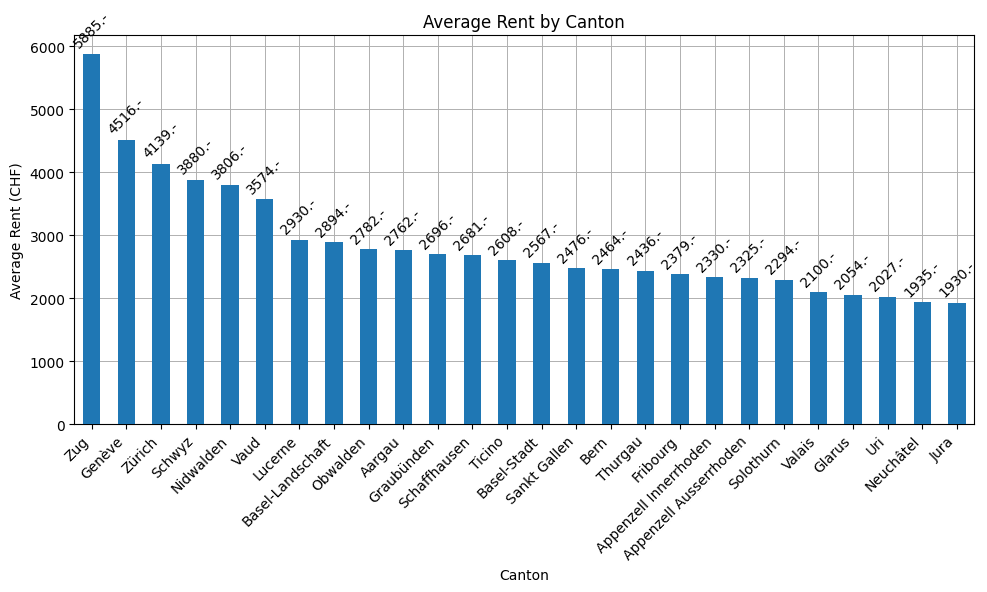

In [10]:
# Convert the listings data to a DataFrame
df = pd.DataFrame(listings_clean)

# Group by 'canton' and calculate the average 'price'
average_rent_by_canton = df.groupby('canton')['price'].mean().sort_values(ascending=False)

# Plot the data
plt.figure(figsize=(10, 6))
average_rent_by_canton.plot(kind='bar', zorder=10)
plt.grid(which='major', axis='both', linestyle='-', linewidth=0.7, zorder=0)
# Add value labels on top of each bar
for i, value in enumerate(average_rent_by_canton):
  plt.text(i, value + 50, f'{value:.0f}.-', ha='center', va='bottom', rotation=45, zorder=3)

plt.title('Average Rent by Canton')
plt.xlabel('Canton')
plt.ylabel('Average Rent (CHF)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## 4.4 Most expensive cities to live in

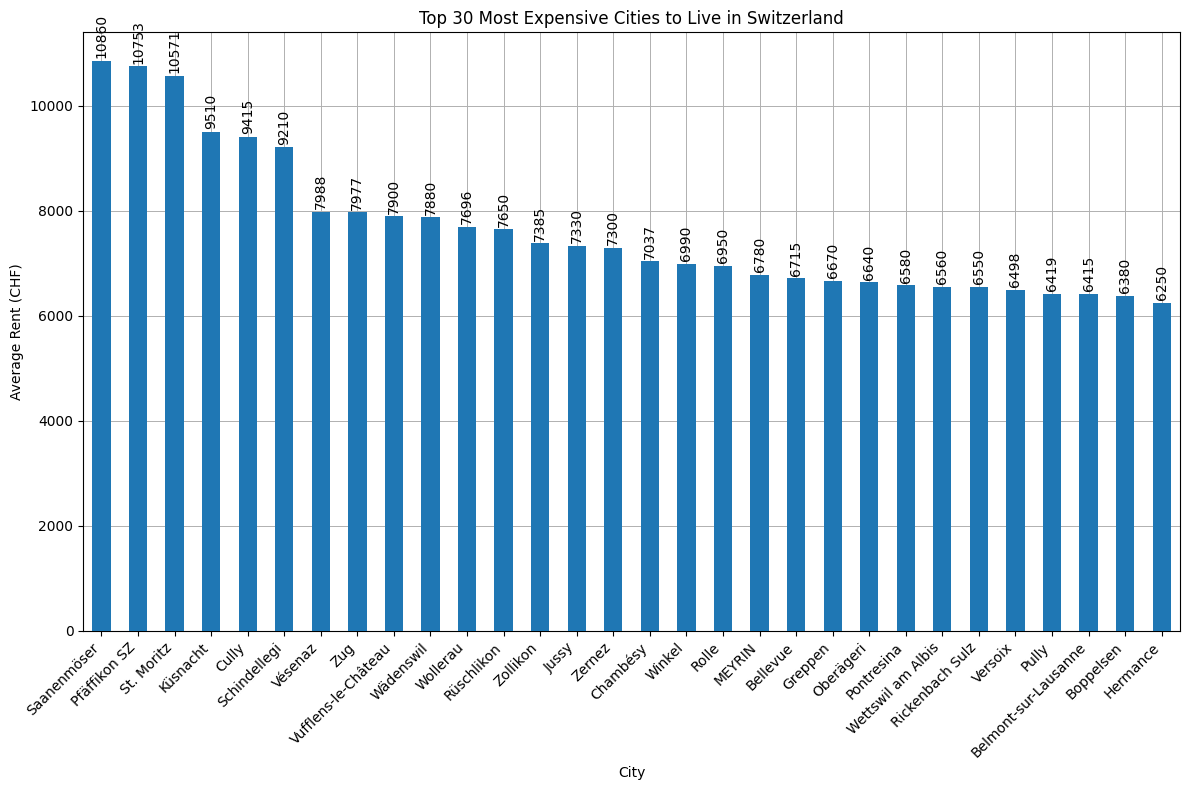

In [11]:
# Convert the listings data to a DataFrame
df = pd.DataFrame(listings_clean)

# Group by 'municipality' and calculate the average 'price'
average_rent_by_city = df.groupby('municipality')['price'].mean().sort_values(ascending=False)

# Select the top 30 most expensive cities
top_30_expensive_cities = average_rent_by_city.head(30)

# Plot the data
plt.figure(figsize=(12, 8))
bars = top_30_expensive_cities.plot(kind='bar', zorder=3)

# Add value labels on top of each bar with vertical orientation
for i, value in enumerate(top_30_expensive_cities):
    plt.text(i, value + 50, f'{value:.0f}', ha='center', va='bottom', rotation=90)

# Add square grid to the plot and set it behind the bars
plt.grid(which='major', axis='both', linestyle='-', linewidth=0.7, zorder=0)

plt.title('Top 30 Most Expensive Cities to Live in Switzerland')
plt.xlabel('City')
plt.ylabel('Average Rent (CHF)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

## 4.5 Top 5 most expensive cities per canton

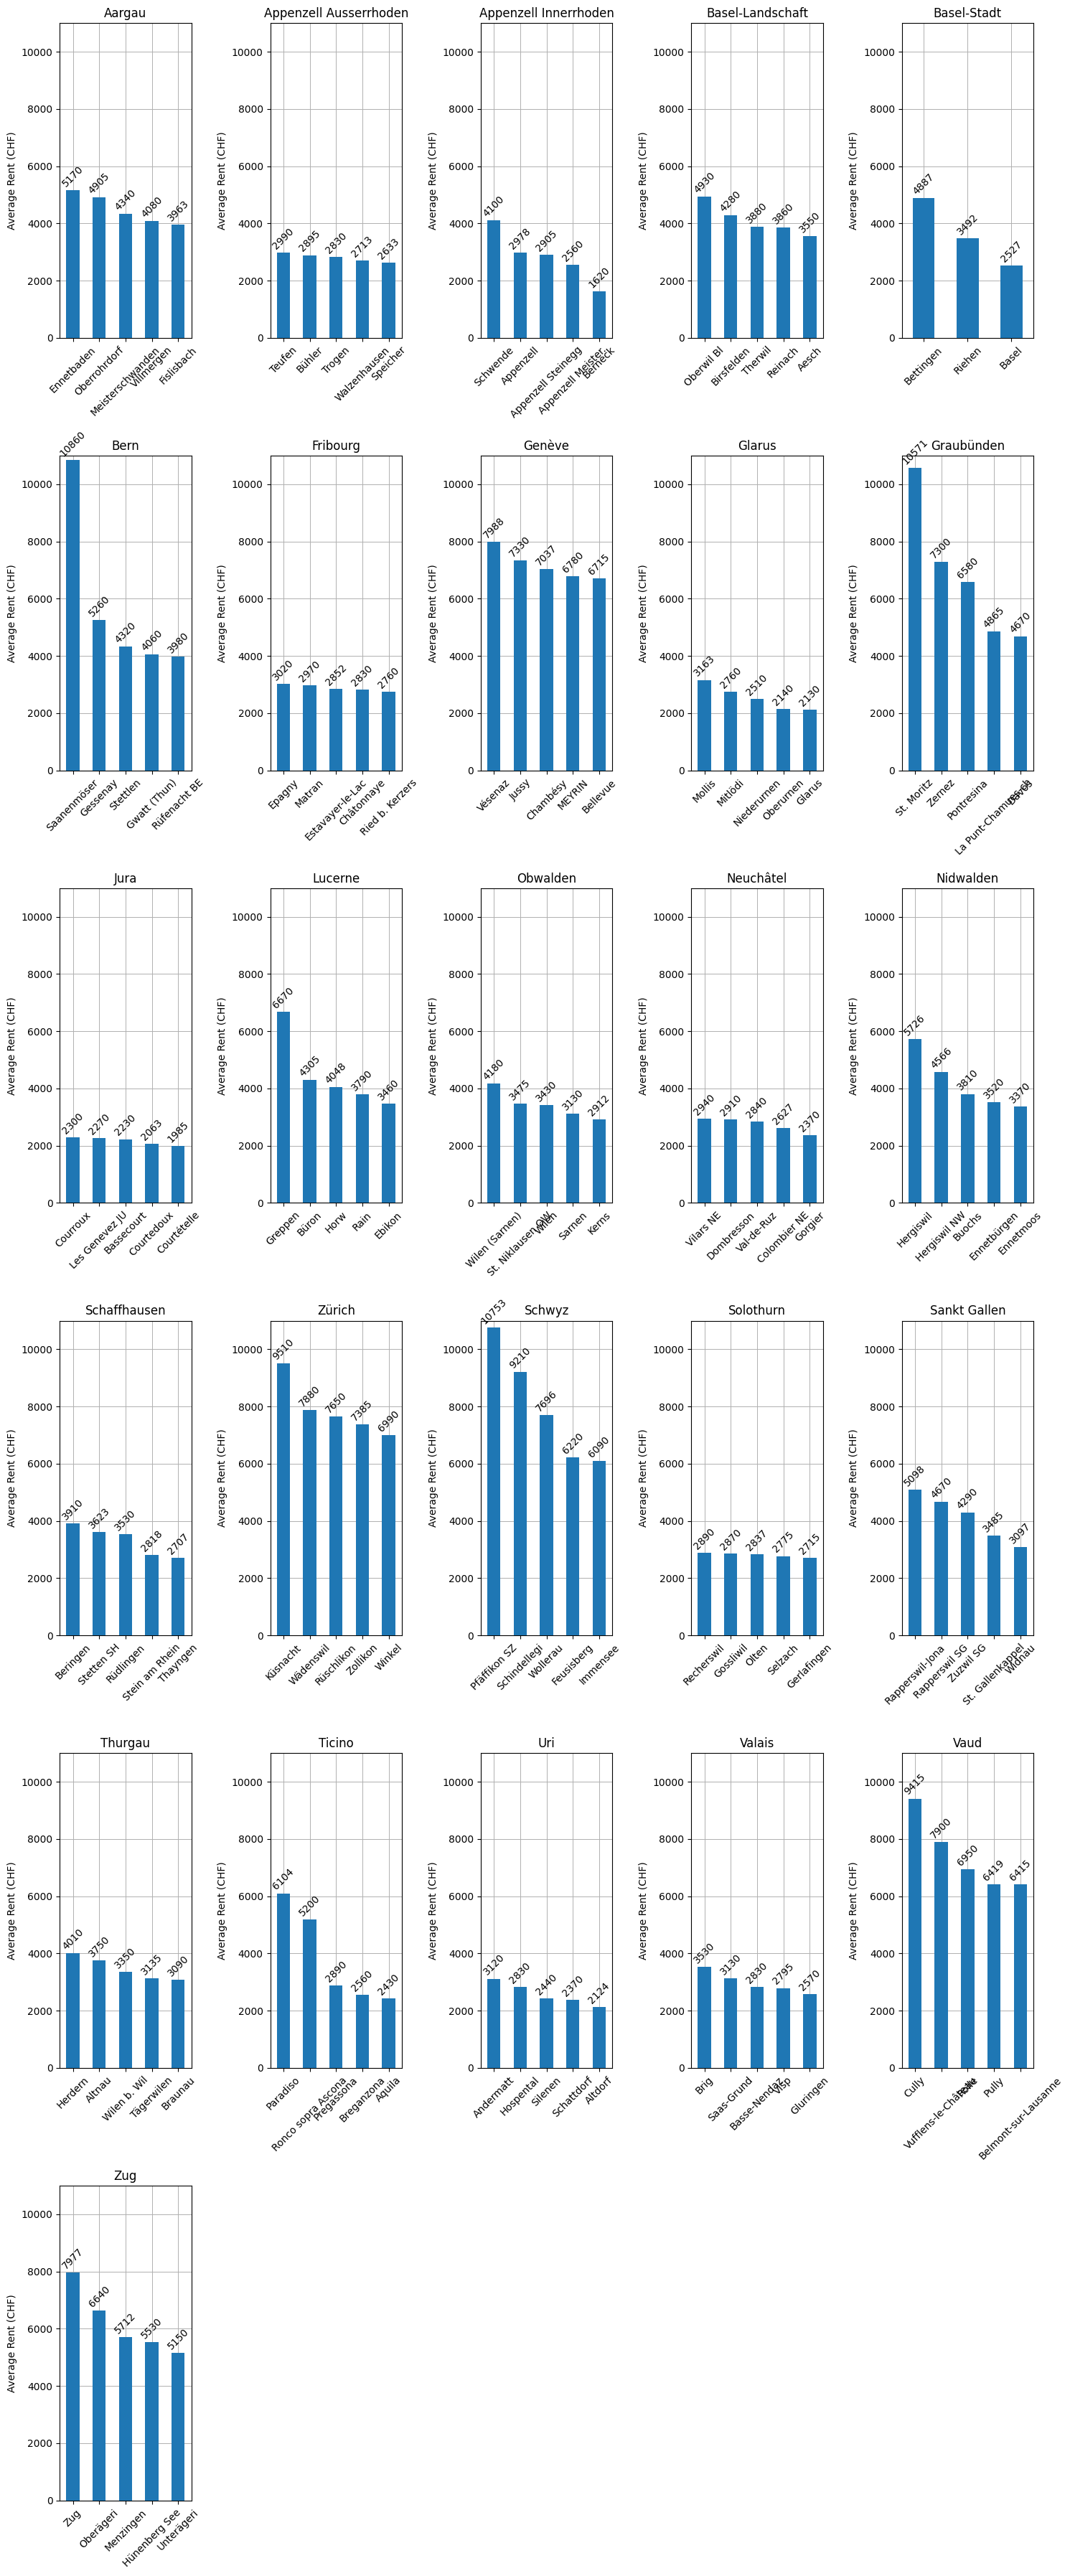

In [15]:
# Convert the listings data to a DataFrame
df = pd.DataFrame(listings_clean)

# Get the list of unique cantons
cantons = df['canton'].unique()

# Number of subplots (one per canton)
num_cantons = len(cantons)

# Set up the subplots grid (with dynamic row/col based on number of cantons)
cols = 5
rows = math.ceil(num_cantons / cols)

fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 6))
axs = axs.flatten()

# Loop through each canton
for idx, canton in enumerate(cantons):
    # Filter the data for the current canton
    canton_df = df[df['canton'] == canton]

    # Group by 'municipality' and calculate the average 'price'
    average_rent_by_city = canton_df.groupby('municipality')['price'].mean().sort_values(ascending=False)

    # Select the top 5 most expensive cities in this canton
    top_5_cities = average_rent_by_city.head(5)

    # Plot the data on the corresponding subplot
    top_5_cities.plot(kind='bar', ax=axs[idx], zorder=3)

    # Add value labels on top of each bar with vertical orientation
    for i, value in enumerate(top_5_cities):
        axs[idx].text(i, value + 50, f'{value:.0f}', ha='center', va='bottom', rotation=45)

    # Set titles and labels
    axs[idx].set_ylim(0, 11000)
    axs[idx].set_title(canton)
    axs[idx].set_ylabel('Average Rent (CHF)')
    axs[idx].set_xlabel(None)
    axs[idx].grid(which='major', axis='both', linestyle='-', linewidth=0.7, zorder=0)
    axs[idx].tick_params(axis='x', rotation=45)

# Remove any empty subplots if cantons do not fill the grid perfectly
for i in range(len(cantons), rows * cols):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

# 4.6 How many listings per canton

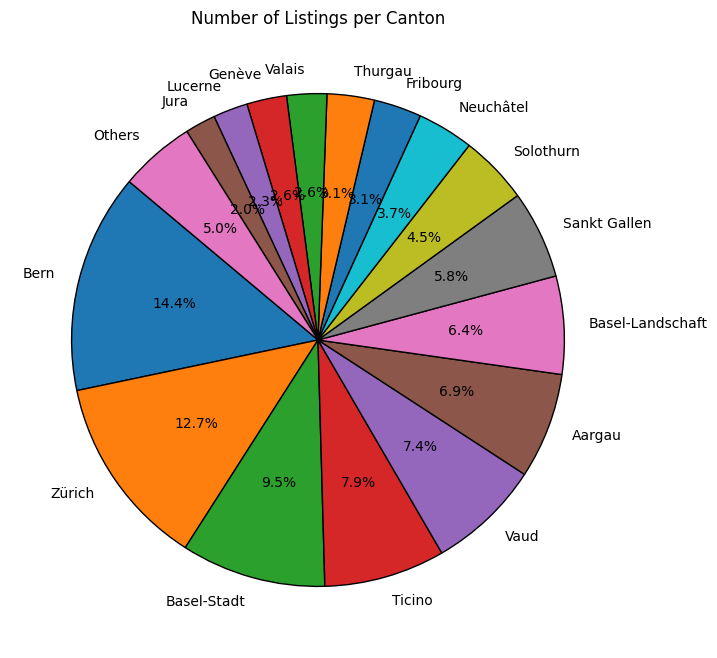

In [32]:
# Convert the listings data to a DataFrame
df = pd.DataFrame(listings_clean)

# Group by 'canton' and count the number of listings per canton
listings_per_canton = df['canton'].value_counts()

# Calculate the percentage of listings per canton
total_listings = listings_per_canton.sum()
listings_percentage = (listings_per_canton / total_listings) * 100

# Group cantons with less than 2% of the listings into 'Others'
canton_threshold = 2
major_cantons = listings_percentage[listings_percentage >= canton_threshold]
minor_cantons = listings_percentage[listings_percentage < canton_threshold]

# Combine minor cantons into 'Others' using pd.concat
if not minor_cantons.empty:
    listings_per_canton_grouped = pd.concat([major_cantons, pd.Series(minor_cantons.sum(), index=['Others'])])
else:
    listings_per_canton_grouped = major_cantons

# Plot a pie chart
plt.figure(figsize=(8, 8))
plt.pie(listings_per_canton_grouped, labels=listings_per_canton_grouped.index, autopct='%1.1f%%', startangle=140, wedgeprops={'edgecolor': 'black'})

# Set a title for the pie chart
plt.title('Number of Listings per Canton')

# Show the pie chart
plt.show()

# 5. Rent estimator
We have now finished displaying all the charts, and we'll move on to presenting a small rent simulator.

We'll start by calculating the average rent per square meter for each municipality. This will allow us to predict rent based on the municipality and the desired area. For example, if you want to live in Pully and are looking for a 70-square-meter apartment, the simulator will give you an estimate of how much you would pay.

Please note, the simulator does not work for all municipalities as there are no listings for some of them. Additionally, the estimated price may not reflect the current market conditions since we only gathered data at one point in time. More frequent data collection over a longer period would be needed for greater accuracy.

We start by computing the average rent per square meter for each municipality:

In [11]:
# Convert the listings data to a DataFrame
df = pd.DataFrame(listings_clean)

# Calculate the price per square meter for each listing
df['price_per_square_meter'] = df['price'] / df['surface']

# Group by postal code and municipality and calculate the average price per square meter
average_price_per_square_meter = df.groupby(['cp', 'municipality'])['price_per_square_meter'].mean().reset_index()

# Create the dictionary in the specified format
prices_per_minicipality = {}

for _, row in average_price_per_square_meter.iterrows():
    prices_per_minicipality[row['cp']] = {
        'municipality': row['municipality'],
        'price_per_square_meter': row['price_per_square_meter']
    }

Try to estimate your future rent !

In [13]:
# The postal code of the municipality where you want to live
postal_code = 1009
# The size of your appartment you wishes
square_meter = 70

try:
  details = prices_per_minicipality[postal_code]

  print(f"Renting prices simulation: ")
  print(f"Postal code: {postal_code}")
  print(f"Municipality: {details['municipality']}")
  print(f"Surface: {square_meter}")
  print(f"Price per meter: {details['price_per_square_meter']:.2f}")
  print(f"Estimated rent: {details['price_per_square_meter'] * square_meter:.2f}.- CHF")
except Exception:
  print(f"We couldn't find details for this municipality. Please try wtith another one.")

Renting prices simulation: 
Postal code: 1009
Municipality: Pully
Surface: 70
Price per meter: 38.65
Estimated rent: 2705.57.- CHF
